In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pickle
import torch
sys.path.append('/usr0/home/yuncheng/MultiBench/')
from supervised_learning import test
from ensemble import test as test_ensemble
from get_data import get_dataloader
from rus import *

In [13]:
# plot utils

def plot(X, y, xlabel, ylabel, label=None, saved_path=None, fit=False, plot='scatter'):
    fig, ax = plt.subplots(figsize=(4,4))
    if plot == 'scatter':
        ax.scatter(X, y)
    elif plot == 'line':
        plt.plot(X, y)
    if label:
        for x in label:
            plt.text(x[0], x[1], x[2])
    # else:
    #     plt.plot(X, y)
    # ax.set_title('{} vs {}'.format(xlabel, ylabel))
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if fit:
        p = np.poly1d(np.polyfit(np.array(X), np.array(y), 1))
        fit_x = list(np.arange(100)/1000*4.5)
        fit_y = []
        for x in fit_x:
            fit_y.append(p(x))
        plt.plot(fit_x, fit_y, linestyle='dashed')
    if saved_path:
        fig.savefig(saved_path+'.pdf', bbox_inches='tight')
    plt.show()

load postprocessed $I_{f(\mathcal{D})}$ and $I_\mathcal{D}$

In [2]:
with open('/usr0/home/yuncheng/MultiBench/synthetic/experiments/results.pickle', 'rb') as f:
    results = pickle.load(f)
print(results['additive']['redundancy'].keys())
with open('/usr0/home/yuncheng/MultiBench/synthetic/experiments/datasets.pickle', 'rb') as f:
    datasets = pickle.load(f)
METHODS = ['additive', 'agree', 'align', 'early_fusion', 'elem', 'mfm', 'mi', 'mult', 'outer', 'lower']
SETTINGS = ['redundancy', 'uniqueness0', 'uniqueness1', 'synergy', 'mix1', 'mix2', 'mix3', 'mix4', 'mix5', 'mix6']
MEASURES = ['redundancy', 'unique1', 'unique2', 'synergy']
print(datasets.keys())

dict_keys(['redundancy', 'unique1', 'unique2', 'synergy', 'acc', 'params', 'unimodal0_acc', 'unimodal1_acc'])
dict_keys(['redundancy', 'uniqueness0', 'uniqueness1', 'synergy', 'mix1', 'mix2', 'mix3', 'mix4', 'mix5', 'mix6'])


normalize $I_\mathcal{D}$ for each $\mathcal{D}$ to get $\hat{I}_\mathcal{D}$

In [3]:
normalized_results = dict()
normalized_datasets = dict()
for method in results:
    normalized_results[method] = dict()
    for setting in SETTINGS:
        normalized_results[method][setting] = dict()
        normalized_datasets[setting] = dict()
        results_total = sum([results[method][setting][measure] for measure in ['redundancy', 'unique1', 'unique2', 'synergy']])
        datasets_total = sum([datasets[setting][measure] for measure in ['redundancy', 'unique1', 'unique2', 'synergy']])
        for measure in MEASURES:
            normalized_results[method][setting][measure] = results[method][setting][measure] / results_total
            normalized_datasets[setting][measure] = datasets[setting][measure] / datasets_total

Print the best-performing models $f^*$ for each $\mathcal{D}$

In [4]:
accs = [results[method][setting]['acc'] for setting in results[method] for method in METHODS]
for setting in SETTINGS:
    measures = sorted([(results[method][setting]['acc'], method) for method in METHODS])
    print(setting, measures[-3:])

redundancy [(0.7405555555555555, 'early_fusion'), (0.7466666666666667, 'lower'), (0.7488888888888889, 'mfm')]
uniqueness0 [(0.7388888888888889, 'lower'), (0.7394444444444445, 'mfm'), (0.7411111111111112, 'outer')]
uniqueness1 [(0.7238888888888889, 'lower'), (0.7261111111111112, 'outer'), (0.7277777777777777, 'mfm')]
synergy [(0.7288888888888889, 'outer'), (0.7361111111111112, 'mfm'), (0.7372222222222222, 'lower')]
mix1 [(0.6577777777777778, 'align'), (0.6594444444444445, 'mult'), (0.6622222222222223, 'mfm')]
mix2 [(0.7066666666666667, 'early_fusion'), (0.7094444444444444, 'lower'), (0.7116666666666667, 'mfm')]
mix3 [(0.7188888888888889, 'outer'), (0.7272222222222222, 'lower'), (0.7366666666666667, 'early_fusion')]
mix4 [(0.6788888888888889, 'mfm'), (0.6805555555555556, 'outer'), (0.6833333333333333, 'lower')]
mix5 [(0.6461111111111111, 'early_fusion'), (0.6555555555555556, 'mfm'), (0.6666666666666666, 'mult')]
mix6 [(0.7133333333333334, 'additive'), (0.7177777777777777, 'mult'), (0.722

Compute agreement $\alpha_I(f,\mathcal{D})$ for all $f,\mathcal{D}$ and $I\in\{R,U_i,S\}$

In [5]:
agreement = dict()
for method in results:
    agreement[method] = dict()
    for setting in SETTINGS:
        agreement[method][setting] = dict()
        for measure in ['redundancy', 'unique1', 'unique2', 'synergy']:
            # agreement[method][setting][measure] = normalized_datasets[setting][measure] * (results[method][setting][measure] - datasets[setting][measure])
            agreement[method][setting][measure] = normalized_datasets[setting][measure] * results[method][setting][measure]

In [14]:
agreement.keys()

dict_keys(['tf', 'mi', 'additive', 'agree', 'align', 'early_fusion', 'elem', 'mfm', 'mult', 'outer', 'lower', 'agree0.1', 'align0.1', 'mfm0.1', 'agree0.2', 'align0.2', 'mfm0.2', 'agree0.5', 'align0.5', 'mfm0.5'])

Compute performance rank for each $f$ on $\mathcal{D}$

In [52]:
ranks = dict()
for setting in SETTINGS:
    measures = sorted([(results[method][setting]['acc'], method) for method in METHODS])
    ranks[setting] = [measure[1] for measure in measures][::-1]
    ranks[setting] = dict([(rank, i+1) for i, rank in enumerate(ranks[setting])])


Examine correlation between $\alpha(f,\mathcal{D})$ and performance of $f$ on $\mathcal{D}$

Print out the top-3 best agreed models for each $\mathcal{D}$

0.7530160016682431


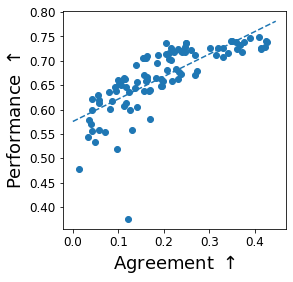

0.807244886761322


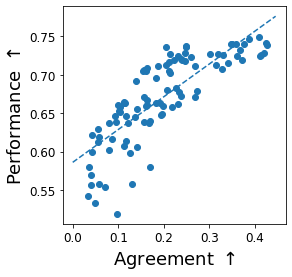

redundancy: agree (agree 0.358585672363788, acc 0.7394444444444445)
redundancy: lower (agree 0.3879796429071534, acc 0.7466666666666667)
redundancy: mfm (agree 0.40834462044403613, acc 0.7488888888888889)
uniqueness0: mfm (agree 0.3767594446533559, acc 0.7394444444444445)
uniqueness0: outer (agree 0.423607766481253, acc 0.7411111111111112)
uniqueness0: lower (agree 0.4272861166609816, acc 0.7388888888888889)
uniqueness1: lower (agree 0.4121193381527135, acc 0.7238888888888889)
uniqueness1: outer (agree 0.41416347156251343, acc 0.7261111111111112)
uniqueness1: mfm (agree 0.4208719213169934, acc 0.7277777777777777)
synergy: outer (agree 0.24611755385738354, acc 0.7288888888888889)
synergy: lower (agree 0.2485755695166394, acc 0.7372222222222222)
synergy: mfm (agree 0.24873119938207305, acc 0.7361111111111112)
mix1: mult (agree 0.19885964706363377, acc 0.6594444444444445)
mix1: align (agree 0.21728532731093383, acc 0.6577777777777778)
mix1: mfm (agree 0.23031275202844342, acc 0.6622222222

In [14]:
ratio = dict()
for method in METHODS:
    ratio[method] = dict()
    for setting in SETTINGS:
        tmp = 0
        for measure in ['redundancy', 'unique1', 'unique2', 'synergy']:
            tmp += agreement[method][setting][measure]
        ratio[method][setting] = tmp
measures = [ratio[method][setting] for setting in SETTINGS for method in METHODS]
accs = [results[method][setting]['acc'] for setting in SETTINGS for method in METHODS]
labels = [(ratio[method][setting], results[method][setting]['acc'], method) for setting in SETTINGS for method in METHODS]
measures_tmp = []
accs_tmp = []
for i, acc in enumerate(accs):
    if acc >= 0.5:
        measures_tmp.append(measures[i])
        accs_tmp.append(accs[i])
print(np.corrcoef(measures, accs)[0,1])
plot(measures, accs, r'Agreement $\uparrow$', r'Performance $\uparrow$', fit=True)
print(np.corrcoef(measures_tmp, accs_tmp)[0,1])
plot(measures_tmp, accs_tmp, r'Agreement $\uparrow$', r'Performance $\uparrow$', saved_path='figs/agreement_performance', fit=True)
for setting in SETTINGS:
    measures = sorted([(ratio[method][setting], method) for method in METHODS])
    # print(measures[-3:])
    for agree, method in measures[-3:]:
        print("{}: {} (agree {}, acc {})".format(setting, method, agree, results[method][setting]['acc']))

Examine correlation between model robustness and $U_i$

0.588643538946587
S 0.2436510503352017
R 0.421930454855303
R+S 0.48299287510113037


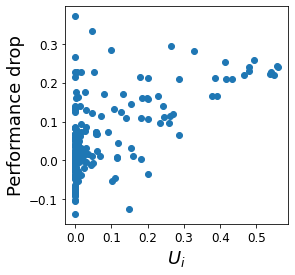

In [15]:
uniqueness = []
unimodal_accs = []
low_synergy = []
low_redundancy = []
low_accs = []
low_synred = []
for i in [0,1]:
    for setting in SETTINGS: 
        for method in METHODS:
            unimodal_accs.append(results[method][setting]['acc']-results[method][setting]['unimodal{}_acc'.format(i)])
            uniqueness.append(results[method][setting]['unique{}'.format(2-i)])
            if results[method][setting]['unique{}'.format(2-i)] < 0.05:
                low_synergy.append(results[method][setting]['synergy'])
                low_redundancy.append(results[method][setting]['redundancy'])
                low_synred.append(results[method][setting]['synergy']+results[method][setting]['redundancy'])
                low_accs.append(results[method][setting]['acc']-results[method][setting]['unimodal{}_acc'.format(i)])
            # labels = [(results[method][setting]['unique{}'.format(2-i)], results[method][setting]['acc']-results[method][setting]['unimodal{}_acc'.format(i)], round(results[method][setting]['synergy'], 2)) for setting in SETTINGS for method in METHODS]
print(np.corrcoef(uniqueness, unimodal_accs)[0,1])
print("S", np.corrcoef(low_synergy, low_accs)[0,1])
print("R", np.corrcoef(low_redundancy, low_accs)[0,1])
print("R+S", np.corrcoef(low_synred, low_accs)[0,1])
plot(uniqueness, unimodal_accs, r'$U_i$', 'Performance drop', saved_path='figs/unimodal_robust')

Examine correlation between $I_\mathcal{D}$, $I\{R,U_i,S\}$ and model performance on each $\mathcal{D}$

In [25]:
for setting in SETTINGS:
    print(setting)
    accs = [results[method][setting]['acc'] for method in METHODS]
    for measure in MEASURES:
        tmp = [agreement[method][setting][measure] for method in METHODS]
        print(measure, np.corrcoef(tmp, accs)[0,1])
    print()

redundancy
redundancy 0.9786196449671446
unique1 -0.16935672048228878
unique2 0.15105705115085946
synergy -0.47905156702160434

uniqueness0
redundancy -0.8737045775826255
unique1 0.7769222657508575
unique2 0.4699462364894213
synergy -0.5674773842865749

uniqueness1
redundancy 0.17551100867595829
unique1 0.623390522171992
unique2 0.9665935785933983
synergy -0.26069218377619907

synergy
redundancy 0.41134501929865386
unique1 0.37297450768056395
unique2 -0.6216423617299026
synergy 0.8557181062790902

mix1
redundancy 0.8120026310072159
unique1 0.41098066399858774
unique2 -0.3056943189522004
synergy 0.718100556407732

mix2
redundancy 0.6047456950535052
unique1 0.8295422799992076
unique2 -0.5289491505484979
synergy 0.7139732696558198

mix3
redundancy 0.6956197927382552
unique1 0.7937585593675184
unique2 -0.6868907844903448
synergy 0.7869647916190825

mix4
redundancy 0.8452579198448074
unique1 0.3778870986367016
unique2 -0.12217429372095687
synergy 0.7759688376163629

mix5
redundancy 0.780296

Format results in $\LaTeX$

In [61]:
for setting in ['redundancy', 'uniqueness', 'synergy']:
    tmp = []
    for method in METHODS:
        if setting == 'uniqueness':
            measure = (results[method][setting+'0']['unique1']+results[method][setting+'1']['unique2'])/2
        else:
            measure = results[method][setting][setting]
        print('&', round(measure, 2), end=' ')
        tmp.append(measure)
    print('&', '{}$\pm${}'.format(round(np.mean(tmp), 2), round(np.std(tmp), 2)))
    tmp = []
    for method in METHODS:
        if setting == 'uniqueness':
            acc = (results[method][setting+'0']['acc']+results[method][setting+'1']['acc'])/2
        else:
            acc = results[method][setting]['acc']
        print('&', round(acc, 2), end=' ')
        tmp.append(acc)
    print('&', '{}\pm{}'.format(round(np.mean(tmp), 2), round(np.std(tmp), 2)))


& 0.35 & 0.48 & 0.44 & 0.47 & 0.27 & 0.55 & 0.2 & 0.4 & 0.47 & 0.53 & 0.41$\pm$0.11
& 0.71 & 0.74 & 0.73 & 0.74 & 0.7 & 0.75 & 0.67 & 0.73 & 0.74 & 0.75 & 0.73\pm0.02
& 0.29 & 0.31 & 0.19 & 0.44 & 0.2 & 0.52 & 0.18 & 0.45 & 0.55 & 0.55 & 0.37$\pm$0.14
& 0.66 & 0.55 & 0.6 & 0.73 & 0.66 & 0.73 & 0.66 & 0.72 & 0.73 & 0.73 & 0.68\pm0.06
& 0.13 & 0.09 & 0.08 & 0.29 & 0.14 & 0.33 & 0.12 & 0.29 & 0.31 & 0.32 & 0.21$\pm$0.1
& 0.56 & 0.66 & 0.63 & 0.72 & 0.66 & 0.74 & 0.65 & 0.72 & 0.73 & 0.74 & 0.68\pm0.06


In [15]:
for setting in SETTINGS:
    for method in ['lower', 'mfm']:
        for measure in MEASURES:
            print('&', round(results[method][setting][measure], 2), end=' ')
        print('&', round(results[method][setting]['acc'], 2), end=' ')
    print('\\\\')

& 0.53 & 0.0 & 0.01 & 0.03 & 0.75 & 0.55 & 0.01 & 0.01 & 0.03 & 0.75 \\
& 0.0 & 0.56 & 0.0 & 0.02 & 0.74 & 0.01 & 0.49 & 0.0 & 0.02 & 0.74 \\
& 0.01 & 0.0 & 0.54 & 0.02 & 0.72 & 0.01 & 0.0 & 0.55 & 0.03 & 0.73 \\
& 0.15 & 0.03 & 0.0 & 0.32 & 0.74 & 0.14 & 0.0 & 0.06 & 0.33 & 0.74 \\
& 0.21 & 0.01 & 0.01 & 0.2 & 0.65 & 0.27 & 0.02 & 0.0 & 0.22 & 0.66 \\
& 0.09 & 0.27 & 0.0 & 0.13 & 0.71 & 0.12 & 0.18 & 0.0 & 0.24 & 0.71 \\
& 0.16 & 0.06 & 0.0 & 0.27 & 0.73 & 0.18 & 0.06 & 0.0 & 0.25 & 0.72 \\
& 0.31 & 0.01 & 0.01 & 0.16 & 0.68 & 0.41 & 0.02 & 0.02 & 0.13 & 0.68 \\
& 0.13 & 0.0 & 0.29 & 0.04 & 0.64 & 0.17 & 0.0 & 0.26 & 0.05 & 0.66 \\
& 0.31 & 0.0 & 0.13 & 0.04 & 0.7 & 0.39 & 0.0 & 0.15 & 0.03 & 0.72 \\
